In [1]:
import numpy as np
import networkx as nx
import classes.nb_general as NB_G
import scipy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
class GraphLibrary:
    
    def __init__(self, direc=''):
        self.direc = direc

    def save_graph(self,G,graph_descrip):
        """ Given a graph and description, save it in our home directory. """
        
        with open('{}/graph_descriptions.txt'.format(self.direc), 'r+') as log_:
            i = len(log_.readlines())
            # Record our graph & Description
            log_.write("Graph {}: {}\n".format(i,graph_descrip))
            log_.close()

        nx.write_gml(G,r"{}/graph_{}.gml".format(self.direc,i),str)
        
    def load_graph(self, k):
        """ Given an index, load the specific graph. """
        
        with open('{}/graph_descriptions.txt'.format(self.direc), 'r+') as log_:    
            
            descrip_ = log_.readlines()[k]
            
        G = nx.read_gml(r"{}/graph_{}.gml".format(self.direc,k))
        
        return G, descrip_ 

In [45]:
def get_elements(G, eps=.9):
    """ Given a nx graph G, find each component for backtracking and non-backtracking random walks. """
    
    # Find L, R, and B
    A = nx.to_numpy_array(G)
    L, T = NB_G.create_s_t(G)
    R = T.T
    C, B = NB_G.to_edge_space(G,graph=False,B = True)

    # Normal page rank - dual
    W_ = R@L.T
    D_ = np.diag(W_@np.ones(W_.shape[0]))
    
    pi = R@la.solve(R.T@R,np.eye(R.shape[1]))@np.ones(R.shape[1])
    pr_x = la.solve(np.eye(R.shape[0])-eps*W_.T@la.inv(D_),((1-eps)/la.norm(pi,ord=1))*pi)
    
    # CHANGED THIS ----- Work in progress :) 
    pi_dist = dict.fromkeys(np.arange(0,len(pi),1), pi)
    for i, key_ in enumerate(pi_dist.keys()):
        pi_dist[key_] = pi[i]
    nx_x = nx.pagerank(nx.from_numpy_array(C), eps, tol=1e-8, max_iter=250, personalization=pi_dist)
    
    nx_x = np.fromiter(nx_x.values(), dtype=float)
    vertex_pr = R.T@pr_x
    vertex_pr_nx = R.T@np.array(list(nx.pagerank(nx.Graph(C),alpha=eps,tol=1e-8,max_iter=250).values()))
    vertex_pr_primal_x = np.array(list(nx.pagerank(nx.Graph(G),alpha=eps,max_iter=250, tol=1e-8).values()))

    # Tuple of: analytical dual, numerical dual, analytical vertex, numerical vertex, numerical base
    NORMAL = (pr_x, nx_x, vertex_pr, vertex_pr_nx, vertex_pr_primal_x)
    
    # NB page rank - dual
    D = np.sum(A, axis=0)
    nu = (L@la.inv(np.diag(D)))@np.ones(L.shape[1])
    B_ = W_-np.multiply(W_,W_.T)
    D_f = np.diag(B_@np.ones(B_.shape[0]))
    pr_y = la.solve(np.eye(B_.shape[0])-eps*B_.T@la.inv(D_f), ((1-eps)/L.shape[1])*nu)
    nx_y = nx.pagerank(nx.from_numpy_array(B), eps, tol=1e-8, max_iter=250)
    nx_y = np.fromiter(nx_y.values(), dtype=float)
    vertex_pr_nb = L.T@pr_y
    vertex_pr_nb_nx = L.T@np.array(list(nx.pagerank(nx.Graph(B),alpha=eps, tol=1e-8, max_iter=250).values()))
    NON_BACK = (pr_y, nx_y, vertex_pr_nb, vertex_pr_nb_nx)
    
    return NORMAL, NON_BACK

In [46]:
def print_results(NORM, NB):
    if np.var(NB[0])/np.var(NORM[0]) < 1:
        STATUS_a = 'FALSE'
    else:
        STATUS_a = 'TRUE'
        
    if np.var(NB[1])/np.var(NORM[1]) < 1:
        STATUS_n = 'FALSE'
    else:
        STATUS_n = 'TRUE'
        
    print("Normal Edge Space")
    print("Analytical: {}".format(np.var(NORM[0])))
    print("Numerical: {}".format(np.var(NORM[1])))
    
    print("\nNB Edge Space")
    print("Analytical: {}".format(np.var(NB[0])))
    print("Numerical: {}".format(np.var(NB[1])))
    
    print("\nDifference")
    print("Analytical: {}".format(np.var(NB[0])/np.var(NORM[0])))
    print("Numerical: {}".format(np.var(NB[1])/np.var(NORM[1])))
    
    print("\nConjecture based on analytical solution: {}".format(STATUS_a))
    print("Conjecture based on numerical solution: {}".format(STATUS_n))
    
    print("\n-------------------------\n")
    
    if np.var(NB[2])/np.var(NORM[2]) < 1:
        STATUS_a_p = 'FALSE'
    else:
        STATUS_a_p = 'TRUE'
        
    if np.var(NB[3])/np.var(NORM[3]) < 1:
        STATUS_n_p = 'FALSE'
    else:
        STATUS_n_p = 'TRUE'
        
    print("Projection To Primal Space")
    print("Analytical: {}".format(np.var(NORM[2])))
    print("Numerical: {}".format(np.var(NORM[3])))
    
    print("\nNB Edge Space")
    print("Analytical: {}".format(np.var(NB[2])))
    print("Numerical: {}".format(np.var(NB[3])))
    
    print("\nDifference")
    print("Analytical: {}".format(np.var(NB[2])/np.var(NORM[2])))
    print("Numerical: {}".format(np.var(NB[3])/np.var(NORM[3])))
    
    print("\nConjecture based on analytical solution: {}".format(STATUS_a_p))
    print("Conjecture based on numerical solution: {}".format(STATUS_n_p))

In [4]:
def graph_results(X, Y):
    """ Given the 4 page rank vectors, graphs them out. """
    
    DOMAIN_d = np.arange(0, len(X[0]), 1)
    DOMAIN_p = np.arange(0, len(X[3]), 1)
    
    min_ = min([min(X[0]),min(Y[0])])
    max_ = max([max(X[0]),max(Y[0])])
    
    plt.figure(figsize=(15,5))
    plt.suptitle("Analytical Solutions (Springer Equations)")
    plt.subplot(121)
    plt.title("Dual Space")
    plt.axis([0,len(X[0]), min_-(min_*.01),max_+(max_*.01)])
    plt.plot(DOMAIN_d, X[0], 'o--', label='Normal')
    plt.plot(DOMAIN_d, Y[0], 'o--', label='NB Constraint')
    
    plt.subplot(122)
    plt.title("Primal Space")
    #plt.axis([0,len(x), min_-(min_*.01),max_+(max_*.01)])
    plt.plot(DOMAIN_p, X[2], 'o--', label='Normal, from dual')
    plt.plot(DOMAIN_p, Y[2], 'o--', label='NB Constraint')
    plt.show()
    
    plt.figure(figsize=(15,5))
    plt.suptitle("Numerical Solutions (Network X)")
    plt.subplot(121)
    plt.title("Dual Space")
    #plt.axis([0,len(X[2]), min_-(min_*.01),max_+(max_*.01)])
    plt.plot(DOMAIN_d, X[1], 'o--', label='Normal')
    plt.plot(DOMAIN_d, Y[1], 'o--', label='NB Constraint')
    
    plt.subplot(122)
    plt.title("Primal Space")
    #plt.axis([0,len(x), min_-(min_*.01),max_+(max_*.01)])
    plt.plot(DOMAIN_p, X[3], 'o--', label='Normal, from dual')
    plt.plot(DOMAIN_p, Y[3], 'o--', label='NB Constraint')
    plt.plot(DOMAIN_p, X[4], 'o--', label='Normal, nx')
    plt.legend(loc='best', fontsize=15)
    plt.show()

In [5]:
def run(G, eps=.9):
    X, Y = get_elements(G, eps)
    graph_results(X,Y)

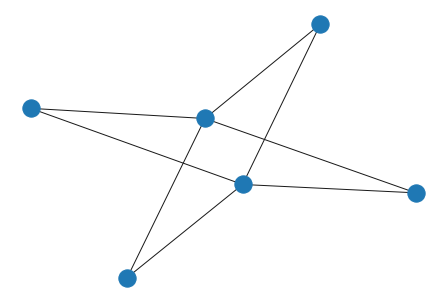

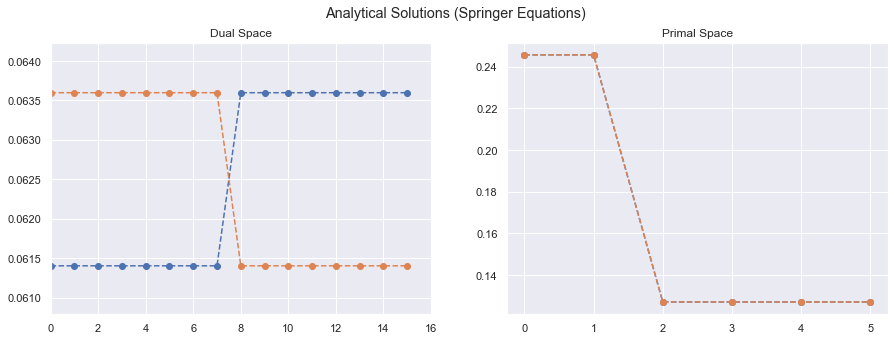

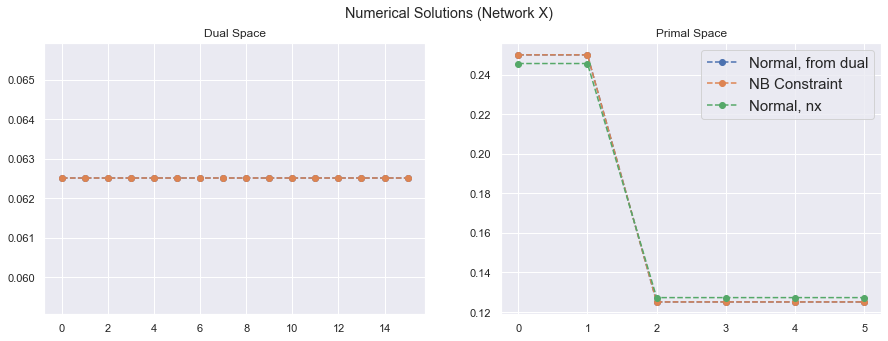

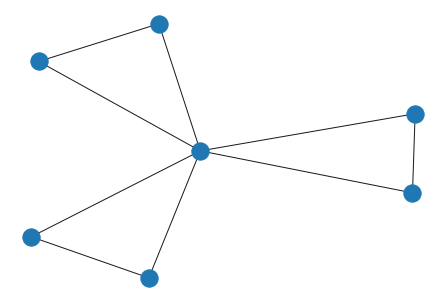

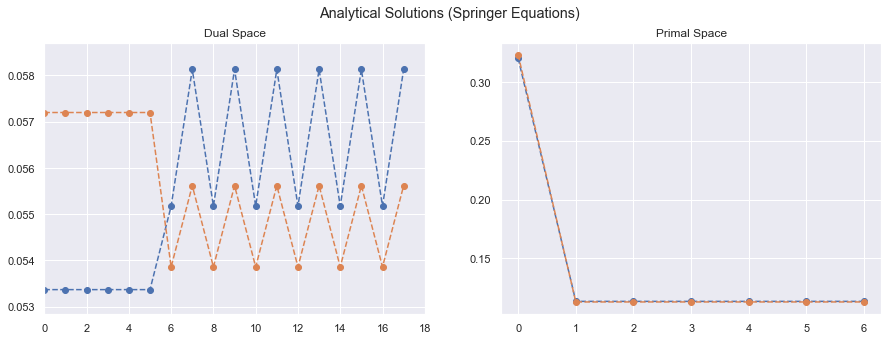

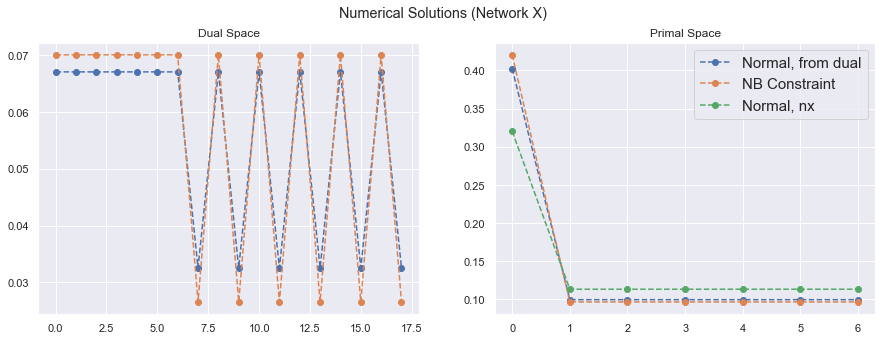

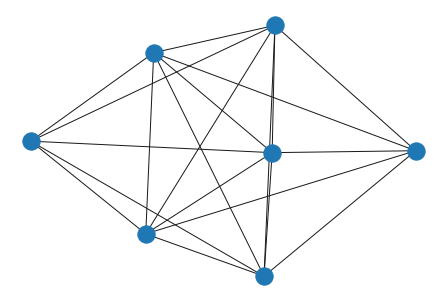

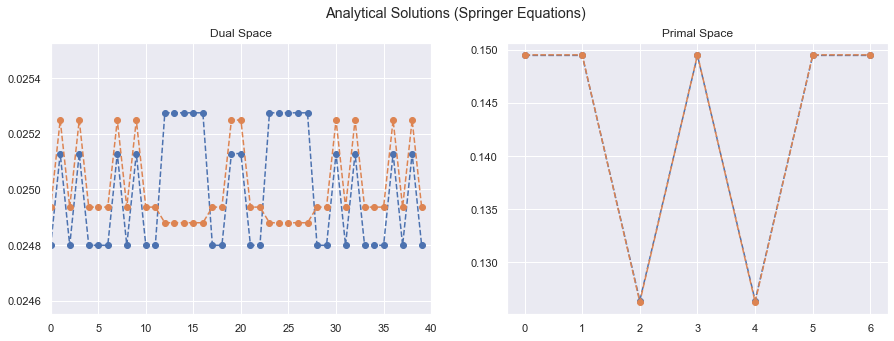

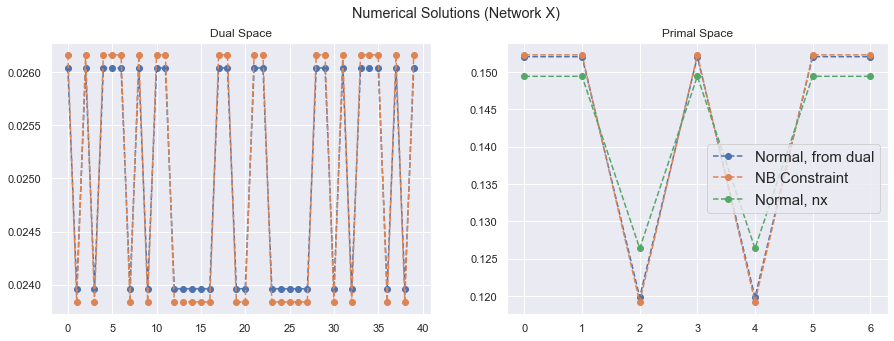

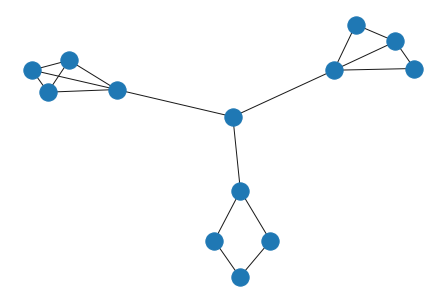

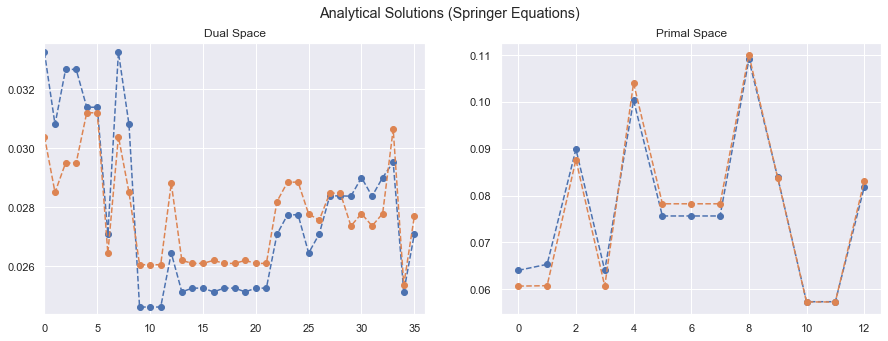

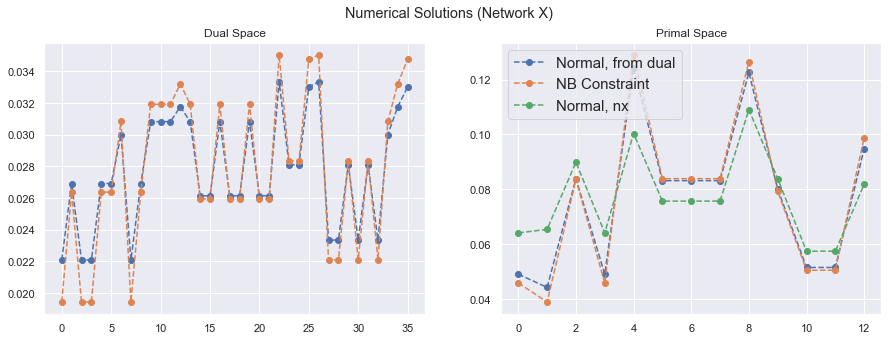

In [6]:
GAO = GraphLibrary('Test_Graphs/GRAPHS')
for i in range(4):
    eps=.9
    G, descrip = GAO.load_graph(k=i)
    nx.draw(G)
    run(G, eps)
    print("\n")

## Conclusions

There seems to be a good deal of numerical instability going on. We see that:

1. In the dual space, both the ordering and magnitude of the vector differs greatly. 

2. In the primal space, the power method gives page rank values with much less variance than the analytical solution. It appears we get the same ordering, yet greatly different values on page rank depending on if we solve the dual, and cast it down, or just use the power method on the primal.

# Just looking at variances

In [47]:
GAO = GraphLibrary('Test_Graphs/GRAPHS')
for i in range(4):
    eps=.9
    G, descrip = GAO.load_graph(k=i)
    X, Y = get_elements(G, eps)
    print_results(X, Y)
    print("\n@@@@@@@@@@@@@@@@@@@@@@@@@@@@@\n")

Normal Edge Space
Analytical: 1.2022930132348338e-06
Numerical: 1.2022834268343826e-06

NB Edge Space
Analytical: 1.202293013234849e-06
Numerical: 2.407412430484045e-35

Difference
Analytical: 1.0000000000000127
Numerical: 2.0023668103142468e-29

Conjecture based on analytical solution: TRUE
Conjecture based on numerical solution: FALSE

-------------------------

Projection To Primal Space
Analytical: 0.0031163434903047093
Numerical: 0.003472222222222226

NB Edge Space
Analytical: 0.0031163434903047067
Numerical: 0.0034722222222222233

Difference
Analytical: 0.9999999999999991
Numerical: 0.9999999999999992

Conjecture based on analytical solution: FALSE
Conjecture based on numerical solution: FALSE

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Normal Edge Space
Analytical: 3.8526882986426635e-06
Numerical: 0.00022323575410918733

NB Edge Space
Analytical: 1.8594290251292431e-06
Numerical: 0.00042007984746344026

Difference
Analytical: 0.4826315759269538
Numerical: 1.881776730343895

Conjecture base

In [44]:
for i in range(10):
    eps=.9
    
    V = np.random.randint(7, 15)
    E = np.random.randint(V, int(V*(V-1)/2)+1)
    G = nx.gnm_random_graph(V,E)
    
    try:
        X, Y = get_elements(G, eps)
        print_results(X, Y)
        print("\n@@@@@@@@@@@@@@@@@@@@@@@@@@@@@\n")
    except:
        print("Singular Matrix...")


Normal Edge Space
Analytical: 1.861440115333976e-06
Numerical: 1.119275540997964e-05

NB Edge Space
Analytical: 7.790395722202084e-07
Numerical: 1.5162720749063693e-05

Difference
Analytical: 0.4185144425559103
Numerical: 1.3546906184999243

Conjecture based on analytical solution: FALSE
Conjecture based on numerical solution: TRUE

-------------------------

Projection To Primal Space
Analytical: 0.0009809482472258645
Numerical: 0.0016789009778692056

NB Edge Space
Analytical: 0.0010076691226526674
Numerical: 0.0017720272665522011

Difference
Analytical: 1.0272398421653435
Numerical: 1.05546860113286

Conjecture based on analytical solution: TRUE
Conjecture based on numerical solution: TRUE

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Normal Edge Space
Analytical: 3.337221696863774e-07
Numerical: 3.5921687362574592e-06

NB Edge Space
Analytical: 1.5177547858253093e-07
Numerical: 4.498992597528825e-06

Difference
Analytical: 0.4547959121959599
Numerical: 1.2524446728012422

Conjecture based on anal

# Conclusions

The conjecture of the variance being greater in non backtracking random walks only holds in the primal space, not the dual. It's interesting that somehow in the projection, we lose this behavior, but then gain it back when it's project back to the primal space.

So now I feel like we are kind of back to where we started, needing to look at this from the primal space rather than the dual. However I also feel like I want to gain more intuition as to how this behavior changes with scale, but we might run into computational limits. 

One thought I had was to take a genetic programming approach, and see what graphs have the highest variance with non-backtracking constraints.